In [8]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Please write your name below** (in case the file names get mixed up)

In [9]:
# Aayush Bisht

In this lab specifically, we will generate random data (with some random noise), so that we know the "ground truth" function that represents the distribution. We will thus be able to see how well we can manage to approximate this function. In future labs, we will use "real" data for which we do not the ground truth distribution, similarly to lab 1.

# Linear regression

We will implement two ways to do linear regression.

In ***this part of this lab only***, since we are interested in recovering a ground truth function, we will not bother splitting the dataset into train/validatation/test sets. In general, *we obviously don't know the ground truth function*. So one of the only ways to ensure that we are not overfitting will be to split the dataset. This is what we will do in other sections and future labs.

## Data generation

Let's generate some fake data (area and age) for houses, and try to predict their price.

Let's start by generating $N$ 2-dimensional training samples, and concatenate them in a matrix $\mathbf{X}_{train}$ of size (N,2)

In [10]:
# Data generation
np.random.seed(42) # we use a random seed so that our random generation is reproducible
N = 50 # number of samples to generate

house_area = np.random.uniform(50,300,size=N) # generate N samples uniformly distributed from 50 to 300
house_age = np.random.uniform(0,150,size=N) # similar

X_train = np.concatenate([
    house_area.reshape(-1,1),
    house_age.reshape(-1,1)
], axis=1) # concatenate the featurs into one input matrix
print(f"Shape of the feature matrix: {X_train.shape}")

Shape of the feature matrix: (50, 2)


In [11]:
# my own created cell
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(X_train[:3])   # first 3 rows (features)
print(y_train[:3])   # first 3 targets


<class 'numpy.ndarray'> (50, 2)
<class 'numpy.ndarray'> (50,)
[[143.63502971 145.43769416]
 [287.6785766  116.2699235 ]
 [232.99848545 140.92484123]]
[ 85.71492094 256.81643576 186.29471726]


Now let's generate the labels $\mathbf{y}_{train}$. We will generate labels that are linear with respect to the input data, with some added random noise that can for instance represent naturally occuring randomness or measurements errors.

In [12]:
# Label generation
noise = np.random.normal(0,5,size=N) # generate some normally distribution random noise
house_price = 1.1 * house_area - 0.5 * house_age + noise # the target is a linear combination of inputs + noise

y_train = house_price
print(f"Shape of the labels vector: {y_train.shape}")

Shape of the labels vector: (50,)


Let's quickly visualize the relation between the target and each individual variable.

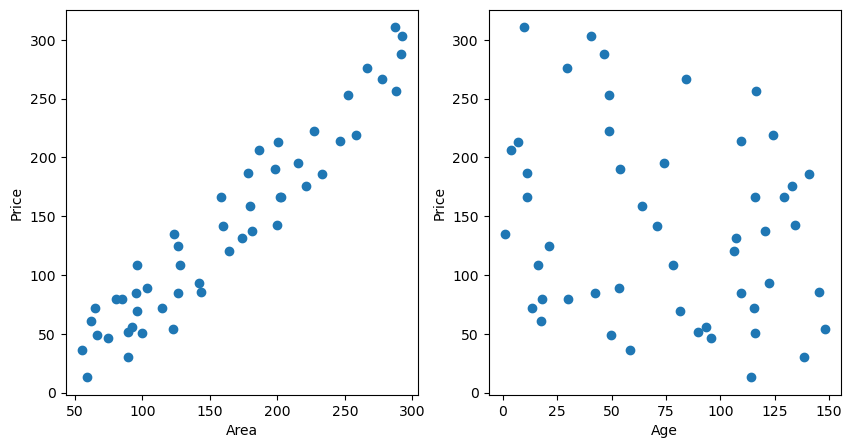

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5)) # create 2 plots size by size

# First scatter plot
ax1.scatter(house_area, house_price)
ax1.set_xlabel('Area')
ax1.set_ylabel('Price')

# Second scatter plot
ax2.scatter(house_age, house_price)
ax2.set_xlabel('Age')
ax2.set_ylabel('Price')
plt.show()

We can also display the ground truth lines:

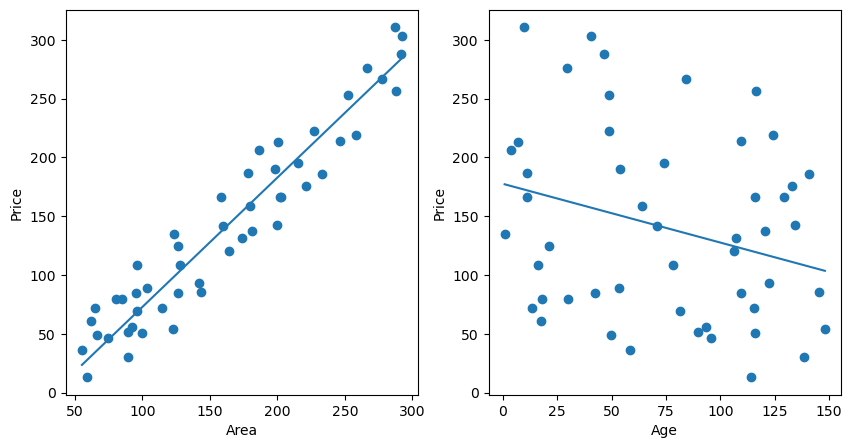

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5)) # create 2 plots size by size

# First scatter plot
ax1.scatter(house_area, house_price)
ax1.set_xlabel('Area')
ax1.set_ylabel('Price')
x_range_area = np.array([house_area.min(), house_area.max()]) # leftmost and rightmost points on the x axis
y_preds_area = 1.1 * x_range_area - 0.5 * house_age.mean() # corresponding points on the y_axis
ax1.plot(x_range_area, y_preds_area)


# Second scatter plot
ax2.scatter(house_age, house_price)
ax2.set_xlabel('Age')
ax2.set_ylabel('Price')
x_range_age = np.array([house_age.min(), house_age.max()]) # same
y_preds_age = 1.1 * house_area.mean() - 0.5 * x_range_age # same
ax2.plot(x_range_age, y_preds_age)
plt.show()

Notice that to draw the ground truth line for each variable, we also had to take into account the mean impact of the other variable.

## Linear regression implementation: gradient descent

**Are the generated data and ground truth function realistic?**

No, because in reality situation is totally different. There are lot of factors that comes into play.

Now let's do linear regression! We will assume there is no intercept, i.e. $f(\mathbf{x}) = \mathbf{w}^\top\mathbf{x}$ (there is no additional $w_0$ term)

Given the parameters $\mathbf{w} = (w_1,w_2)^\top$ and the training data $\mathbf{X}$,
predictions can be made with $\hat{\mathbf{y}} = \mathbf{Xw}$

In [15]:
# For example, with an arbitrary vector w:
w_init = np.array([1,2]) # assign random values to w

y_est = X_train @ w_init # compute predictions
print(f"Shape of our predictions: {y_est.shape}")

Shape of our predictions: (50,)


**Implement a function that returns the Mean Square Error (MSE):**
$$J(\mathbf{w}) = \frac{1}{N}  \lVert \mathbf{y} - \mathbf{Xw} \rVert_2^2$$
**given the training data $\mathbf{X}$, labels $\mathbf{y}$ and model parameters $\mathbf{w}$**

In [16]:
import numpy as np

def mse(X, y, w):
    y_pred = X @ w
    err = y - y_pred
    return np.mean(err ** 2)

def mse_grad(X, y, w):
    N = X.shape[0]
    y_pred = X @ w
    return (2.0 / N) * (X.T @ (y_pred - y))

**How can we estimate the gradient $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$?** (no code required either, just a formula)

$$
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}
= \frac{2}{N}\,\mathbf{X}^{\top}\big(\mathbf{X}\mathbf{w}-\mathbf{y}\big)
$$


***Bonus question: what if we did not have an analytical solution?*** (no code required either, just an *optional* very brief answer)

**Implement gradient descent:
$\mathbf{w}_{(t)} = \mathbf{w}_{(t-1)} - \alpha \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$**

**and determine suitable values for the parameters $\mathbf{w}$ using gradient descent on the training samples.**

It may be useful to print the training error at each step. If the loss/error is not decreasing, try a smaller value of the learning rate $\alpha$.

In [17]:
def gradient_descent(X, y, w_start, alpha=0.00002, num_iters=2000, print_every=200):
    w = w_start.astype(float).copy()
    previous_w = w
    for t in range(num_iters):
        g = mse_grad(X, y, w)
        w = w - alpha * g

        if t % print_every == 0 or t == num_iters - 1:
            current_loss = mse(X, y, w)
            print(f"iter {t:4d}: MSE = {current_loss:.6f}")
            
        # CONVERGENCE_THRESHOLD = 0.001 # stops at (approx) 50th iteration
        CONVERGENCE_THRESHOLD = 0.0001 
        norm_change_of_w = np.linalg.norm(previous_w - w)
        if np.linalg.norm(previous_w - w) <= CONVERGENCE_THRESHOLD:
            print("repeated value, stopping")
            break
        previous_w = w
    return w

# run it
w_gd = gradient_descent(X_train, y_train, w_init, alpha=0.00002, num_iters=100, print_every=10)
# print("Estimated weights from GD:", w_gd)
print("Final training MSE:", mse(X_train, y_train, w_gd))

iter    0: MSE = 16568.011285
iter   10: MSE = 1413.757631
iter   20: MSE = 202.549301
iter   30: MSE = 44.523757
iter   40: MSE = 23.906256
iter   50: MSE = 21.216303
iter   60: MSE = 20.865346
iter   70: MSE = 20.819557
repeated value, stopping
Final training MSE: 20.81471104405803


**Are your estimated values of the parameters consistent with the ground_truth?**

yes, it's same.

## Linear regression implementation: analytical solution and comparison

**Now use the closed-form solution to obtain good values for the parameters $\mathbf{w}$ using the training set.**

In [18]:
# .T means transpose
# np.linalg.inv finds inverse

def normal_eq(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

In [19]:
w_analytic = normal_eq(X_train, y_train)
print(f"Analytical solution weights: {w_analytic}")

Analytical solution weights: [ 1.0909023  -0.48668339]


**Display the exact values of the parameters $\mathbf{w}$.
Are they the same as the one you obtained from gradient descent?
Are they the same as the ground truth values? Why?**

In [20]:
print(f"Ground truth: [1.1, -0.5]")
print(f"Estimated with gradient descent: {w_gd}")
print(f"Estimated with closed-form solution: {w_analytic}")

Ground truth: [1.1, -0.5]
Estimated with gradient descent: [ 1.09054575 -0.48584122]
Estimated with closed-form solution: [ 1.0909023  -0.48668339]


All the values are almost same, there is a subtle difference.

In practice, a machine learning engineer does not waste time implementing standard algorithms.
Scikit-learn provides an implementation of a linear regression, among many other learning algorithms.

(Obviously, YOU are not wasting time, because you are learning. Implementing a linear regression is something *everyone* should do at least once in their life).

**Look at the documentation from scikit-learn, and train a linear regression on our data using the provided implementation.
Look at the coefficients $\mathbf{w}$. Are they similar to the ones you found?**

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# Creating and training the model
# .coef_ stores the learned weight

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X_train, y_train)


linreg.coef_

array([ 1.0909023 , -0.48668339])

# Over- and under-fitting polynomials

## Data generation

Let's define a new "ground-truth" function $f(x) = x \cdot \text{sin}(x)$, and plot it on $[0,10]$

In [23]:
def f(x: float) -> float:
    """
    Take an float (or an array of floats as input)
    and apply the corresponding function
    """
    return np.sin(x) / x

Let's randomly sample $N$ points $\mathbf{X}_{}$ in range $[1,10]$, and create corresponding labels $\mathbf{y}_{}$ by applying this function and adding some random noise.

(Note: here, since we have a single input feature ($D=1$), $\mathbf{X}_{}$ is actually an $N$-dimensional vector and not an $(N \times D)$ matrix. We could therefore write $\mathbf{x}_{}$ (lowercase) instead. But since we may consider that a vector is an $(N \times 1)$ matrix, we will keep writing $\mathbf{X}_{}$ for the sake of consistency.)

In [24]:
# Data generation
np.random.seed(42) # we use a random seed so that our random generation is reproducible
N = 20 # number of samples to generate

X_full = np.random.uniform(1,10,size=N)
noise = np.random.randn(N)
y_full = f(X_full) + 0.1 * noise

Finally, let's display the sampled points and the ground truth function.

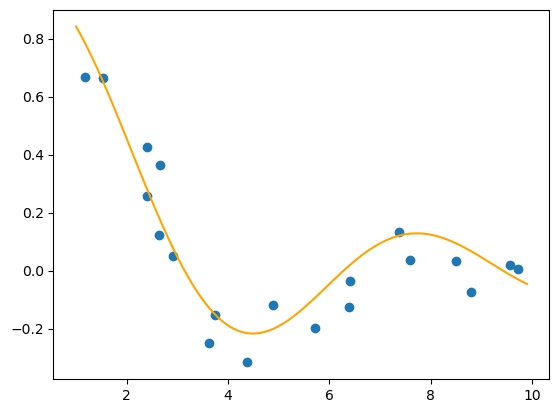

In [25]:
x_range = np.arange(1,10,0.1) # sample points along the x-axis
y_ground_truth = f(x_range) # compute corresponding points on the y-axis
plt.plot(x_range, y_ground_truth, color='orange') # plot the corresponding line
plt.scatter(X_full, y_full) # plot the sampled points
plt.show()

Notice that we do not have many training samples, as may be the case for some real use cases.

We will now assume *we do not know* the ground truth function. We will instead use the sampled points as training and testing examples to try to predict the corresponding labels, try to fit a polynomial curve and evaluate the results.

Let's start by splitting our data into a training a testing set:

In [26]:
# Training set
X_train = X_full[:12] # 12 first elements of X_full
y_train = y_full[:12] # 12 first labels of y_full
# Testing set
X_test = X_full[12:] # remaining elements of X_full
y_test = y_full[12:] # remaining elements of y_full

## Fitting polynomials

**Does it look like fitting a simple linear regression would provide good predictions?**

No, Simple LR makes a straight line and in this dataset we have generated data from curvy/wave function. So it would be a poor fit or underfit.

**Complete the following function that create polynomial features**

In [27]:
def get_polynomial_features(X: np.ndarray, degree=3) -> np.ndarray:
    """
    Return polynomial features;
    if i-th element of input X is a,
    i-th output element is 1 + a + a^2 + ... + a^degree
    
    Args:
        X: vector (1D array) of features, shape (N,)
        degree: int, the maximum degree of the polynomial
    
    Returns:
        polynomial_features: matrix of shape (N, degree+1)
    """
    #TODO: complete the function
    N = X.shape[0]
    
    powers = [np.ones(N)]
    for i in range(degree):
        new_power = powers[-1] * X 
        powers.append(new_power) 
    return np.array(powers).T

**Fit a polynomial of degree 3 to the training data. Plot the corresponding curve along with the training samples.**

To achieve this, you may use either the Scikit-learn implementation of linear regression, your own implementation, or any other method that you deem relevant.

(Optionnaly, go directly to next question, which also includes this question.)

**Do the same for degrees 1 to 10. Which degree seems to yield the lowest training error?**

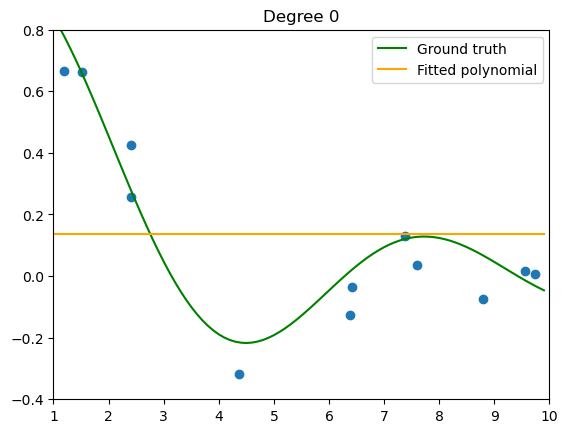

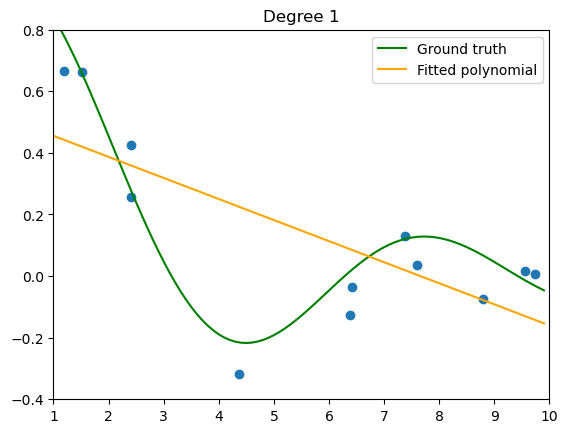

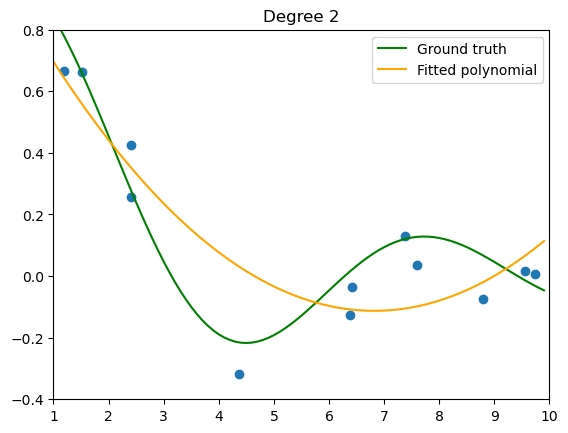

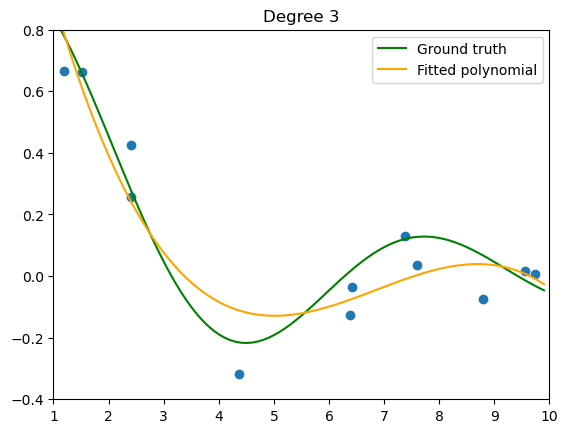

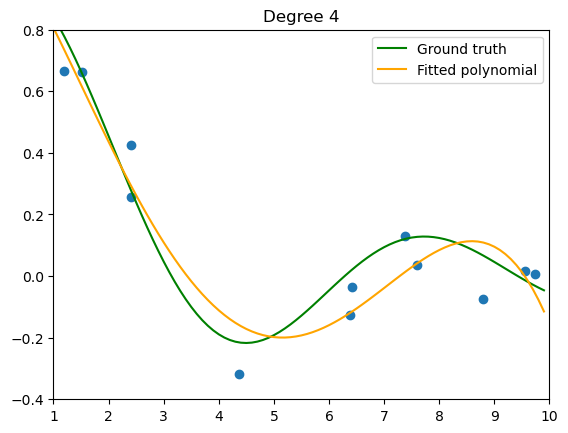

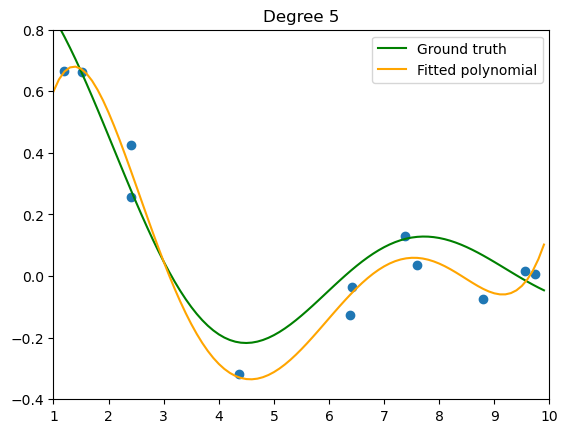

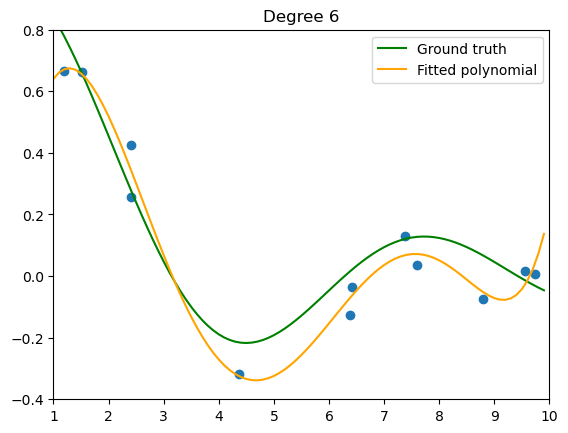

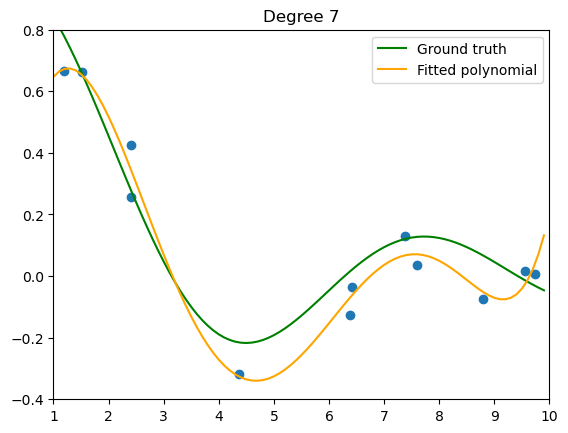

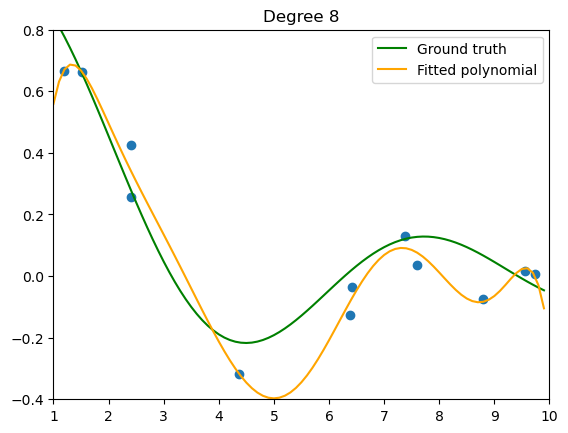

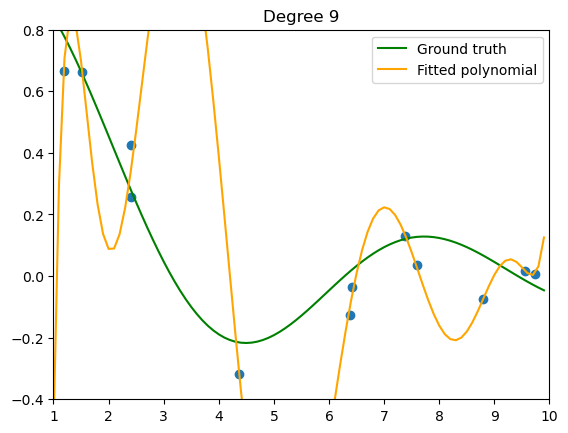

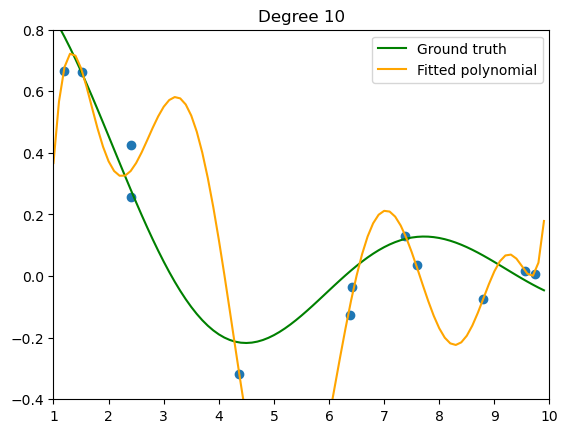

In [40]:
fitted_polynomials = []
degrees = range(10+1)

for degree in degrees:
    
    X_poly = get_polynomial_features(X_train, degree=degree)
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X_poly, y_train)
    fitted_polynomials.append(linreg)
    
    plt.title(f"Degree {degree}")
    plt.xlim(1,10)
    plt.ylim(-0.4,0.8)
    plt.plot(x_range, y_ground_truth, color='green', label="Ground truth") 
    plt.scatter(X_train, y_train)
    
    x_range_poly = get_polynomial_features(x_range, degree=degree) 
    y_estimated = linreg.predict(x_range_poly) 
    plt.plot(x_range, y_estimated, color='orange', label="Fitted polynomial") 
    plt.legend()
    plt.show()

    
    

    
    


    


## Measuring error

**What is the training error for each of the polynomial degree we fitted? What about the test error?**

You may plot the train and test error with respect to the degree of the polynomials

In [29]:
def mean_square_error(y_est: np.ndarray, y: np.ndarray) -> float:
    """
    Compute the MSE from predictions and ground truth labels

    Args:
        y_est: vector of estimated labels, shape (N,)
        y: vector of true labels, shape (N,)
    """
    return ((y - y_est)** 2).mean()

In [38]:
training_errors, testing_errors = [], []

for degree in degrees:
    fitted_poln = fitted_polynomials[degree] 
    
    X_poln_train = get_polynomial_features(X_train, degree=degree) # polynomial feature transformation
    y_preds_train = fitted_poln.predict(X_poln_train) #
    train_error = mean_square_error(y_preds_train, y_train) 
    training_errors.append(train_error)
    
    X_poln_test = get_polynomial_features(X_test, degree=degree)
    y_preds_test = fitted_poln.predict(X_poln_test)
    test_error = mean_square_error(y_preds_test, y_test)
    testing_errors.append(test_error)

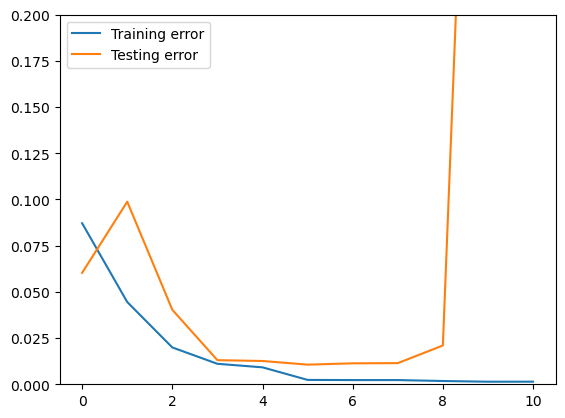

In [37]:
# Plotting result

plt.plot(degrees, training_errors, label="Training error")
plt.plot(degrees, testing_errors, label="Testing error")
plt.ylim([0,0.2])
plt.legend()
plt.show()

**Interpret this in terms of under- and over-fitting**

underfitting degree 1 & 2
overfitting degree 8 and after

**Which degree seems to be most appropriate for a practical use case? Why?**

degree 3 to 8, as it is nearest to ground truth.

Final note: here, the degree of the polynomial could typically be considered to be a hyper-parameter of the model. We did not do a proper selection of this hyper-parameter using a validation set, but ideally, we should have done so instead of selecting the best value for the degree direclty on the test set. Otherwise, this could lead to inaccurate estimate of the performance of the model.